### Проведем Feature engineering& EDA

In [1]:
import json
import pickle
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from scipy.sparse import hstack

Настроим ноутбук

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = 12, 8
RANDOM_STATE=42

#### Возьмем полученный ранее объединенный датасет


In [3]:
df = pd.read_csv('data1.csv')
print(f"{df.shape=}")

df.shape=(71765, 34)


C:\Users\User-PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Подготовим используемые функции

* fit_and_score_model - оценивает переданнух модель на кросс валидации, и выводит среднее значение метрики mape
* make_submit - делает предсказание модели на тестовых данныхЪ и сохраняет их в файл predict.csv
* prepare_data - подгаталивает тренировочный и тестовый набор (на основании переданного списка колонок)

In [4]:
def mape(y_true, y_pred):
    """оценка MEAN ABSOLUTE PERCENTAGE ERROR, которая используется в соревновании"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    
def fit_and_score_model(model, X, y):
    """Оцениваем модель и данные на трех фолдах. Выводим средюю оценку, и оценки на фолдах"""
    
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    cv_results = cross_val_score(
        model, X, y, cv=kf, n_jobs=-1, scoring=make_scorer(mape))
    
    model.fit(X_train,y)
    train_score = mape(y, model.predict(X_train))
    
    print("#"*100)
    print(model)
    print(f"train shape {X.shape}")
    print(f"{cat_cols=}")
    print(f"{num_cols=}")
    print("#"*100)
    print(f"Train result: {train_score}")
    print(f'CV result: {np.mean(cv_results)} ({cv_results})')
    print("#"*100)


def make_submit_file(model, X_test, file_name='predict.csv'):
    """запишем предсказание модели в файл, готовый к отправке на kaggle"""
    pred = np.round(model.predict(X_test))
    answer = pd.Series(pred, index=df[~df.is_train].sell_id, name='price')
    answer.to_csv(file_name, index_label='sell_id')


def prepare_data(categorical_columns: list, numerical_columns: list):
    """Вытащим требуемые данные из глобальной переменной df
    к категориальным применим dummy кодирование
    к числовым Шкалирование"""
    X = df.loc[:, categorical_columns+numerical_columns+['is_train']]

    X = pd.get_dummies(X, columns=categorical_columns)
    X[numerical_columns] = StandardScaler().fit_transform(X[numerical_columns])
    
    X_train = X[X.is_train == 1].drop('is_train', axis=1)
    X_test = X[X.is_train == 0].drop('is_train', axis=1)

    y = df[df.is_train].price

    return X_train, X_test, y

### Используем в качестве модели Случайный лес

In [5]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'engineDisplacement', 'mileage', ]

In [6]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [7]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [8]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (37079, 832)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'engineDisplacement', 'mileage']
####################################################################################################
Train result: 5.352067448508653
CV result: 13.299726812856742 ([13.54160944 12.9206982  13.4368728 ])
####################################################################################################
Wall time: 2min 1s


In [9]:
pd.Series(model.feature_importances_,
          index=X_train.columns).sort_values(ascending=False).iloc[:20]

engineDisplacement                 0.38
mileage                            0.34
productionDate                     0.08
brand_MERCEDES                     0.06
Привод_передний                    0.02
vendor_EUROPEAN                    0.01
vendor_JAPANESE                    0.01
model_name_MAYBACH S-КЛАСС         0.01
model_name_G-КЛАСС AMG             0.01
bodyType_минивэн                   0.00
model_name_S-КЛАСС                 0.00
model_name_GLE                     0.00
model_name_G-КЛАСС                 0.00
vehicleTransmission_механическая   0.00
model_name_W188                    0.00
brand_LEXUS                        0.00
model_name_V-КЛАСС                 0.00
brand_SKODA                        0.00
model_name_XC90                    0.00
model_name_MAYBACH GLS             0.00
dtype: float64

In [10]:
X_test.engineDisplacement.fillna(df.engineDisplacement.mean(), inplace=True)

In [11]:
make_submit_file(model, X_test, "1_baseline_random_forest_100.csv")

### EDA

* Посмотреть корреляцию данных
* Посмотреть пропуски если получиться и заполнить их
* Анализировать колонки

#### Ищем корреляцию

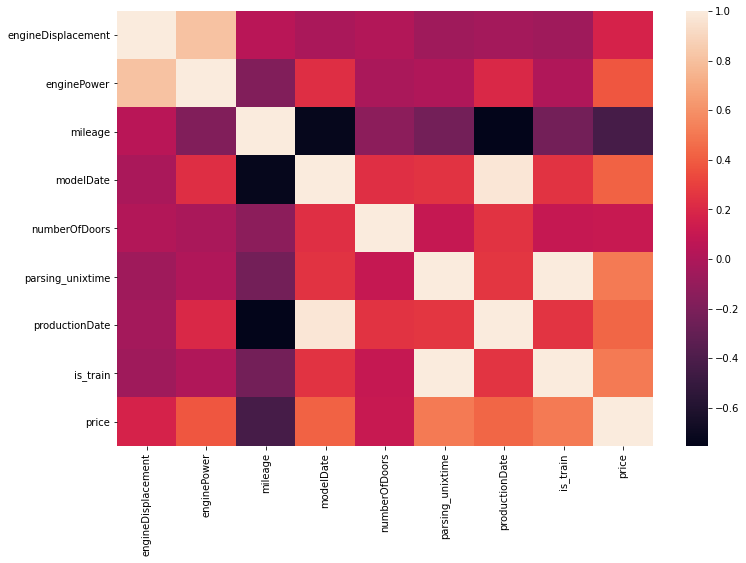

In [12]:
sns.heatmap(df.corr());

#### Выводы по диаграмме корреляции:
* production_date коррелирует с model_date - оставляем ону колонку
* bp engine dicplacement коррелирует с engine power - оставляем одну колонку
* mileage отрицательно коррелрует с modelDate, productionDate и price

### Исследуем пропуски

In [13]:
df.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description               732
engineDisplacement         55
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                52125
ПТС                         0
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
is_train                    0
price     

### Выводы

* complectation_dict, description, equipment_dict - это поля, из которых мы будем получать доп.сведения пока пропуски в этих полях не используем (как и сами поля)
* engineDisplacement надо заполнить
* Владение - пока не используем, но нужно будет поработать с этим полем

### Заполним пропуски в engineDisplacement

Посмотрим какой тип топлива у машин с пропусками в этом поле

In [14]:
df[df.engineDisplacement.isna()].fuelType.value_counts()

электро    55
Name: fuelType, dtype: int64

Так как электро автомобили - не имеют ДВС установим значение 0.0

In [15]:
df[df.fuelType=='электро'].engineDisplacement.value_counts()

0.00    80
Name: engineDisplacement, dtype: int64

In [16]:
df.loc[df.fuelType=='электро','engineDisplacement'] = df.loc[df.fuelType=='электро','engineDisplacement'].fillna(0)

### Рассмотрим колонку bodyType

In [17]:
df.bodyType.value_counts()

внедорожник 5 дв.          29316
седан                      24254
лифтбек                     5645
хэтчбек 5 дв.               3785
универсал 5 дв.             2314
минивэн                     1696
купе                        1577
компактвэн                   856
хэтчбек 3 дв.                775
пикап двойная кабина         563
внедорожник 3 дв.            219
купе-хардтоп                 204
фургон                       173
кабриолет                    158
родстер                      140
микровэн                      21
седан-хардтоп                 17
седан 2 дв.                   13
пикап одинарная кабина        11
лимузин                        7
пикап полуторная кабина        6
внедорожник открытый           4
минивэн caravan elgrand        3
тарга                          2
седан-хардтоп ceres            2
фастбек                        1
универсал 3 дв.1               1
универсал 5 дв. qualis         1
универсал 3 дв.                1
Name: bodyType, dtype: int64

Сгруппируем и понаблюдаем сводную таблицу по типам авто и их цене

In [18]:
df.groupby(['bodyType', 'is_train'])['price'].agg(
    ['count', 'min', 'mean', 'max'])

count      min         mean       max
bodyType                is_train                                       
внедорожник 3 дв.       False       115        0         0.00         0
                        True        104   105000   485,451.91   3500000
внедорожник 5 дв.       False     12228        0         0.00         0
                        True      17088    90000 2,830,068.23  25999000
внедорожник открытый    False         3        0         0.00         0
                        True          1  1250000 1,250,000.00   1250000
кабриолет               False        90        0         0.00         0
                        True         68   420000 2,247,398.26  14000000
компактвэн              False       489        0         0.00         0
                        True        367    35000   498,644.04   1967000
купе                    False       824        0         0.00         0
                        True        753    50000 2,848,576.68  52500000
купе-хардтоп            False       158        0         0.00         0
                        True         46   180000 1,646,359.89   5000000
лимузин                 False         6        0         0.00         0
                        True          1  8000000 8,000,000.00   8000000
лифтбек                 False      2232        0         0.00         0
                        True       3413    70000 1,289,605.72  18033500
микровэн                False         7        0         0.00         0
                        True         14   130000   544,428.57    997000
минивэн                 False       995        0         0.00         0
                        True        701    60000 2,621,529.43  26400000
минивэн caravan elgrand True          3   340000   766,000.00   1498000
пикап двойная кабина    False       280        0         0.00         0
                        True        283   180000 1,738,524.35  13220000
пикап одинарная кабина  False         5        0         0.00         0
                        True          6   739000 2,271,839.83   3998000
пикап полуторная кабина False         5        0         0.00         0
                        True          1  4700000 4,700,000.00   4700000
родстер                 False        99        0         0.00         0
                        True         41   350000 3,564,830.83  21800000
седан                   False     13147        0         0.00         0
                        True      11107    25000 1,553,748.59  58093592
седан 2 дв.             False         6        0         0.00         0
                        True          7   150000 1,124,571.43   2500000
седан-хардтоп           False        12        0         0.00         0
                        True          5   205000   488,000.00    595000
седан-хардтоп ceres     True          2    95000   137,500.00    180000
тарга                   False         2        0         0.00         0
универсал 3 дв.         True          1   372138   372,138.00    372138
универсал 3 дв.1        True          1   400000   400,000.00    400000
универсал 5 дв.         False      1276        0         0.00         0
                        True       1038    65000 1,066,043.02   7096200
универсал 5 дв. qualis  True          1   345000   345,000.00    345000
фастбек                 False         1        0         0.00         0
фургон                  False        97        0         0.00         0
                        True         76   100000   674,798.39   4950000
хэтчбек 3 дв.           False       485        0         0.00         0
                        True        290    50000   473,242.68   5050000
хэтчбек 5 дв.           False      2124        0         0.00         0
                        True       1661    23000   660,235.98   6690400

### Рассмотрим поле enginePower

Т.к. поля engine power и engine displacement - очень скоррелированы то нужно выбрать одно.
у поля engine power есть преимущество, оно не равно 0 для электрокаров
и расрпделение лог-нормально, можно прологарифмировать его

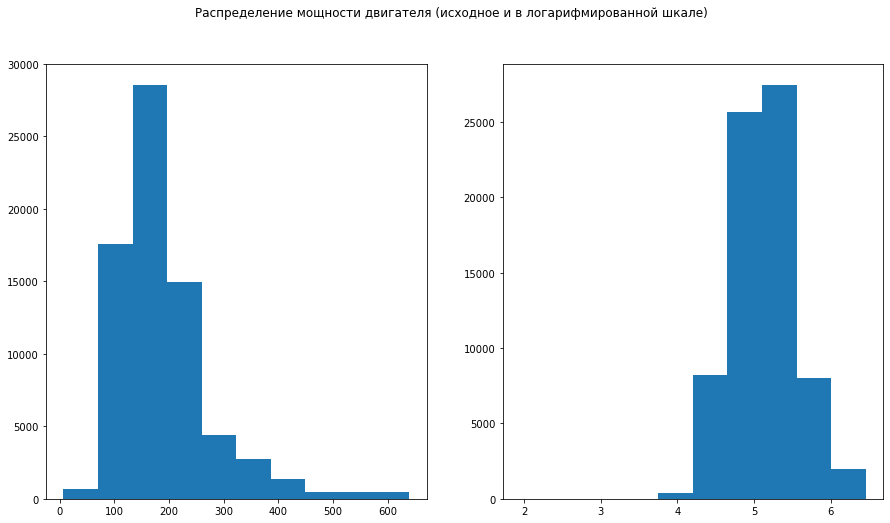

In [19]:
figure, (ax1,ax2) = plt.subplots(1,2,figsize = (15,8))
ax1.hist(df.enginePower)
ax2.hist(np.log(df.enginePower))
figure.suptitle('Распределение мощности двигателя (исходное и в логарифмированной шкале)')
plt.show()

In [20]:
df['enginePower_log'] = np.log(df.enginePower)

### mileage

Поле конечно очень сильно влияет на цену авто.
Отдельной категорией идут автомобили без пробега - выделим их отдельно
и прологорифмируем колонку

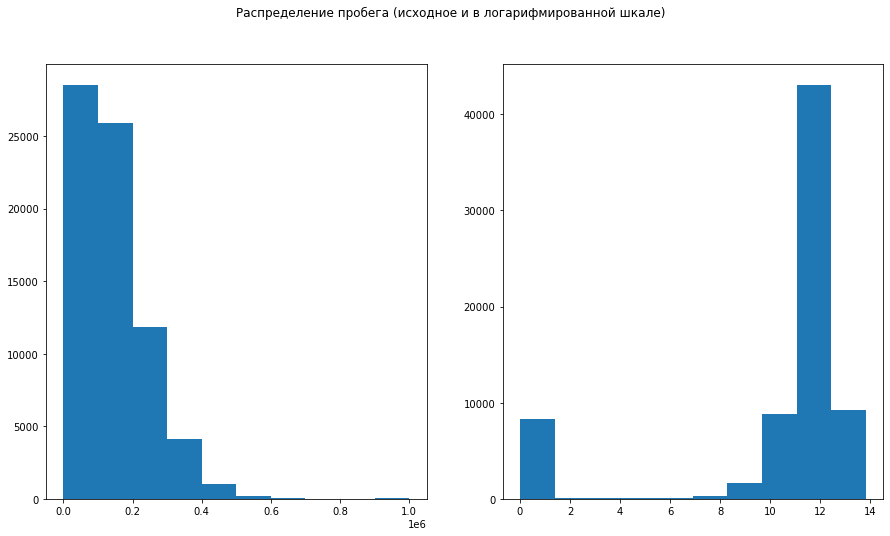

In [21]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.mileage)
ax2.hist(np.log(df.mileage+1))
figure.suptitle('Распределение пробега (исходное и в логарифмированной шкале)')
plt.show()

In [22]:
df['mileage_is_0'] = (df.mileage == 0)
df['mileage_log'] = np.log(df.mileage+1)

## Объединим все вышеприведенное в одну функцию

In [23]:
def feature_enginering_version1(df: pd.DataFrame):
    """запишем сюда все преобразования которые делали в этом разделе ноутбука
    1) заполнили пропуски в поле engineDisplacement для электрокаров
    2) сделали колонку логарифм цены
    3) сделали свернутую колонки тип кузова bodyType_cut
    4) сделали признак enginePower_log - логарифм от мощности двигателя
    5) сделали признак пробег равен 0 mileage_is_0
    6) сделали признак логарифм от пробега"""
    
    df.loc[df.fuelType == 'электро',
           'engineDisplacement'] = df.loc[df.fuelType == 'электро',
                                          'engineDisplacement'].fillna(0)

    #df["price_log"] = np.log(df[df.is_train==1].price)
    
    bodyTypes = {
        'внедорожник открытый': 'внедорожник',
        'внедорожник 5 дв.': 'внедорожник',
        'седан': 'седан',
        'лифтбек': 'хэтчбек',
        'хэтчбек 5 дв.': 'хэтчбек',
        'универсал 5 дв.': 'универсал',
        'минивэн': 'минивэн',
        'купе': 'купе',
        'компактвэн': 'минивэн',
        'хэтчбек 3 дв.': 'хэтчбек',
        'пикап двойная кабина': 'пикап',
        'внедорожник 3 дв.': 'внедорожник',
        'купе-хардтоп': 'купе',
        'кабриолет': 'кабриолет',
        'родстер': 'родстер',
        'фургон': 'фургон',
        'микровэн': 'минивэн',
        'седан-хардтоп': 'седан',
        'седан 2 дв.': 'седан',
        'пикап одинарная кабина': 'пикап',
        'лимузин': 'лимузин',
        'пикап полуторная кабина': 'пикап',
        'внедорожник открытый': 'внедорожник',
        'тарга': 'родстер',
        'фастбек': 'хэтчбек',
        'универсал 3 дв.1': 'универсал',
    }
    #df['bodyType_cut'] = df.bodyType.map(bodyTypes)

    df['enginePower_log'] = np.log(df.enginePower)

    df['mileage_is_0'] = (df.mileage == 0)
    df['mileage_log'] = np.log(df.mileage + 1)

In [24]:
feature_enginering_version1(df)

### Попробуем новые данные в предсказании

In [25]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'engineDisplacement', 'mileage', ]

In [26]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [27]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y, test_size=0.3, shuffle=True, random_state=RANDOM_STATE)

In [32]:
model.fit(X_train, y_train)
pred = model.predict(X_val)
score = mape(pred, y_val)
print(f"MAPE: {score}")

MAPE: 12.089892765034726


Получили значение на отложенной выборке 

Теперь используем кроссвалидацию

In [35]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [36]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (37079, 832)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'engineDisplacement', 'mileage']
####################################################################################################
Train result: 5.351748417774708
CV result: 13.300122800191824 ([13.54188569 12.9191585  13.43932421])
####################################################################################################
Wall time: 2min 2s


На отложенной выборке результат получился лучше, чем при кроссвалидации

### enginePower

In [37]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage', ]

X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [38]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (37079, 832)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage']
####################################################################################################
Train result: 5.066042820765032
CV result: 12.710217267693169 ([12.65397809 12.40405701 13.0726167 ])
####################################################################################################
Wall time: 2min 5s


Показатель enginePower_log помогает лучше нам предсказывать.

### mileage

In [39]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]

X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [41]:
%%time
fit_and_score_model(model, X_train, y)

KeyboardInterrupt: 

Показатель mileage_log тоже немножко улучшил нашу модель

### milleage_is_0

In [42]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'mileage_is_0']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]

X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [43]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (37079, 834)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'mileage_is_0']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log']
####################################################################################################
Train result: 5.075781569676935
CV result: 12.677495889005883 ([12.62094294 12.39945629 13.01208844])
####################################################################################################
Wall time: 2min 5s


Показатель mieage_is_0 никак не помог. Хотя может быть для других видов моделей (линейной) он бы был полезен.

### Линейная регрессия
Сделаем модель Лассо-регрессии, чтобы посмотреть какие коэффициенты обнуляться

In [44]:
model = Lasso(alpha=3)

In [45]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'mileage_is_0']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]

X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [46]:
%%time
fit_and_score_model(model, X_train, y)

C:\Users\User-PC\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4289631513876188e+16, tolerance: 22338945061031.05
  model = cd_fast.enet_coordinate_descent(


####################################################################################################
Lasso(alpha=3)
train shape (37079, 834)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'mileage_is_0']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log']
####################################################################################################
Train result: 53.55282276390011
CV result: 55.42700286367201 ([55.36774441 55.36763635 55.54562783])
####################################################################################################
Wall time: 45.6 s


In [47]:
coefs = pd.Series(model.coef_, index=X_train.columns)
print(coefs.shape)
coefs[coefs==0].index.values

(834,)


array(['bodyType_пикап полуторная кабина', 'bodyType_тарга',
       'bodyType_фастбек', 'color_бежевый', 'color_коричневый',
       'color_пурпурный', 'color_серебристый', 'model_name_02',
       'model_name_02 (E10)', 'model_name_100NX', 'model_name_100_SERIES',
       'model_name_120', 'model_name_140', 'model_name_190_SL',
       'model_name_1ER', 'model_name_240_SERIES', 'model_name_280ZX',
       'model_name_2ACTIVETOURER', 'model_name_2ER',
       'model_name_2GRANDTOURER', 'model_name_350Z', 'model_name_3ER',
       'model_name_4', 'model_name_5ER', 'model_name_6ER',
       'model_name_7ER', 'model_name_8ER', 'model_name_A4_ALLROAD',
       'model_name_ACTY', 'model_name_ALLEX', 'model_name_ALLROAD',
       'model_name_ALMERA_CLASSIC', 'model_name_ALMERA_TINO',
       'model_name_AMG_GLC_COUPE', 'model_name_AMG_GT',
       'model_name_ARTEON', 'model_name_ATLAS',
       'model_name_AVENSIS_VERSO', 'model_name_A_KLASSE',
       'model_name_A_KLASSE_AMG', 'model_name_BLUEBIRD_SYLP

Линейная регрессия конечно очень плохо справилась, но зато можно посмотреть какие коэффициенты она обнулала. Lasso регрессия обнулила 814 коэффициентов, в основном это dummy колонки по model_name

### model_name

В текущем наборе мы эту колонку сделали dummy колонкой и наша Lasso модель обнулила много коэффициентов по ней
наверное стоит сделать ограничение на эту колонку, чтобы не засорять модель 733 новыми колонками
определим, сколько моделей стоит учитывать

увидел что в колонке есть значение с пробелами и с подчеркиваниями (наверное в тесте и в трейне разные парсеры) - исправим это
думаю 50 моделей - нормальное число, как раз только 50 моделей встерчаются более 500 раз, остальные меньше

In [48]:
df.model_name = df.model_name.str.replace(' ', '_')

In [49]:
df.model_name.value_counts()[40:60]

FX              548
GLC             547
S60             530
YETI            509
SUPERB          506
FABIA           497
Q5              489
A5              481
JUKE            477
GLE_COUPE       463
A3              447
RAV_4           447
PAJERO_SPORT    444
C_KLASSE        428
A8              425
MURANO          424
LX              424
X1              411
KODIAQ          409
TERRANO         407
Name: model_name, dtype: int64

In [50]:
top_models = df.model_name.value_counts()[:50].index
df['model_name_cut'] = df.model_name
df.loc[~df.model_name.isin(top_models), 'model_name_cut'] = 'RARE_MODEL'

In [51]:
df.model_name_cut.value_counts()

RARE_MODEL            28190
OCTAVIA                2839
POLO                   1874
OUTLANDER              1637
A6                     1580
LANCER                 1568
QASHQAI                1547
CAMRY                  1496
RAPID                  1354
PASSAT                 1226
A4                     1193
TIGUAN                 1186
X5                     1105
5ER                    1026
LAND_CRUISER            938
RAV4                    907
XC90                    831
E_KLASSE                809
RX                      773
COROLLA                 773
TOUAREG                 769
ALMERA                  758
3ER                     752
CIVIC                   748
LAND_CRUISER_PRADO      743
5_СЕРИИ                 733
X-TRAIL                 715
ASX                     666
X6                      666
GOLF                    657
X_TRAIL                 654
Q7                      648
JETTA                   626
ACCORD                  625
PAJERO                  623
3_СЕРИИ             

model_date & production_date

### model_date&production_date

Распределение почти одинаковое.
А что если добавить колонку разницу этих дат
Ну и по корреляции уже поняли что нужно использовать только одну из этих колонок

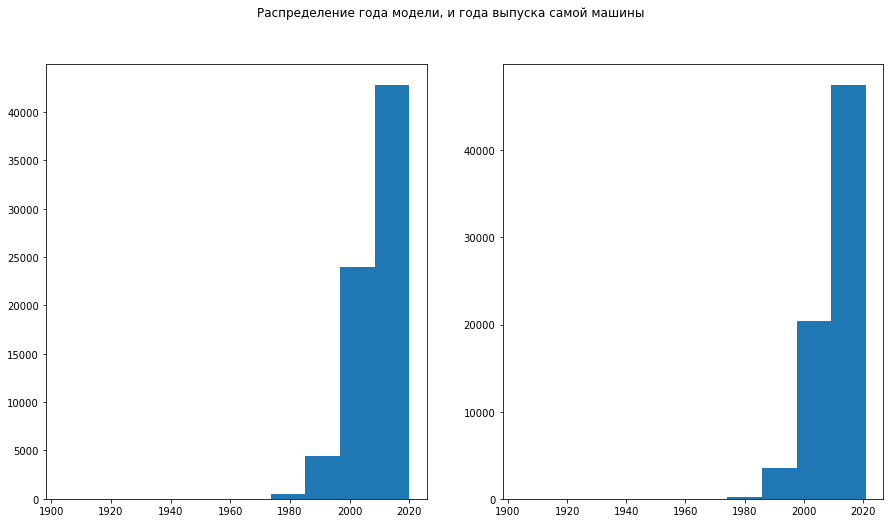

In [52]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.modelDate)
ax2.hist(df.productionDate)
figure.suptitle('Распределение года модели, и года выпуска самой машины')
plt.show()

In [53]:
df['diff_date_model_production'] = df.productionDate-df.modelDate
df['diff_date_model_production_log'] = np.log(df.diff_date_model_production-np.min(df.diff_date_model_production)+1)

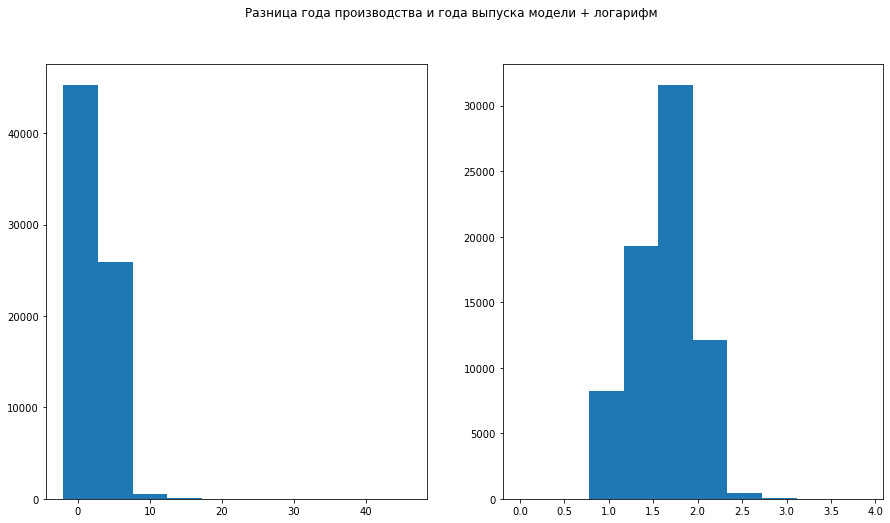

In [54]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.diff_date_model_production)
ax2.hist(df.diff_date_model_production_log)
figure.suptitle('Разница года производства и года выпуска модели + логарифм')
plt.show();

### Владельцы

заменим категориальную переменну числом, ведь это ординальная ,3 владельца болье чем 2 и 2 больше чем 1
но что ставить когда неизвестно! если пробег 0, то и владельцев 0
а если пробег больше 0 то ставим 2 владельца - как среднее в нашей выборке

In [55]:
df['Владельцы'].value_counts()

3 или более    25382
1 владелец     19187
2 владельца    16658
Неизвестно     10538
Name: Владельцы, dtype: int64

In [56]:
df['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', 'Неизвестно'],
      dtype=object)

In [57]:
df[df['Владельцы'] == 'Неизвестно'].mileage.value_counts()

0         8259
300000      62
200000      60
250000      47
220000      33
          ... 
245571       1
247612       1
10000        1
173800       1
114860       1
Name: mileage, Length: 818, dtype: int64

In [58]:
mask = (df['Владельцы'] == 'Неизвестно') & (df.mileage == 0)
df.loc[mask, 'Владельцы'] = "Новая машина"
mask = (df['Владельцы'] == 'Неизвестно') & (df.mileage != 0)
df.loc[mask, 'Владельцы'] = "2\xa0владельца"

In [59]:
df['Владельцы'].value_counts()

3 или более     25382
1 владелец      19187
2 владельца     18937
Новая машина     8259
Name: Владельцы, dtype: int64

In [60]:
df['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', 'Новая машина'],
      dtype=object)

In [61]:
owners_map = {
    'Новая машина':0,
    '1\xa0владелец':1,
    '2\xa0владельца':2,
    '3 или более':3    
}
df['owners'] = df['Владельцы'].map(owners_map)

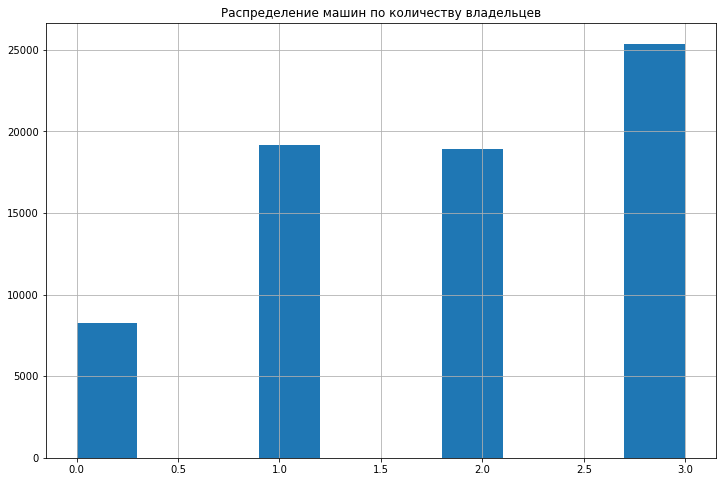

In [62]:
df.owners.hist();
plt.title('Распределение машин по количеству владельцев');

#### В будущем лучше разделить эту колонку на 4 с бинарными значениями

### Владение

много пропущенных значений, больше половины набора данных
сделаем колонку что срок владения укзаан, и больше ничего не будем делать

In [72]:
print(f"процент пропущенных значений: {df['Владение'].isna().sum() / df.shape[0]}")

процент пропущенных значений: 0.7263289904549571


In [73]:
df['Владение'].value_counts()

1 год и 10 месяцев             209
2 года                         197
1 год                          194
1 год и 1 месяц                193
1 год и 2 месяца               187
                              ... 
{'year': 2004, 'month': 9}       1
{'year': 1998, 'month': 8}       1
{'year': 2000, 'month': 11}      1
{'year': 2003, 'month': 7}       1
{'year': 1998, 'month': 5}       1
Name: Владение, Length: 520, dtype: int64

In [74]:
df['own_time_is_na'] = df['Владение'].isna()

### Оформим все вышепредставленные изменения в одну функцию

In [75]:
def feature_enginering_version2(df: pd.DataFrame):
    """запишем сюда все преобразования которые делали в этом разделе ноутбука
    1) В колонке model_name_cut все редкие модели (не в ТОП 50) заменяем на RARE_MODEL
    2) добавляем колонки diff_date_model_production и diff_date_model_production_log
    3) добавляем порядковую колонку owners
    4) добавляем колонку own_time_is_na"""
    
    df.model_name = df.model_name.str.replace(' ', '_')
    
    df['model_name_cut_50'] = df.model_name
    top_models = df.model_name.value_counts()[:50].index
    df.loc[~df.model_name.isin(top_models), 'model_name_cut_50'] = 'RARE_MODEL'
    
    df['model_name_cut_450'] = df.model_name
    top_models = df.model_name.value_counts()[:450].index
    df.loc[~df.model_name.isin(top_models), 'model_name_cut_450'] = 'RARE_MODEL'
    
    df['diff_date_model_production'] = df.productionDate-df.modelDate
    df['diff_date_model_production_log'] = np.log(df.diff_date_model_production-np.min(df.diff_date_model_production)+1)
    
    mask = (df['Владельцы'] == 'Неизвестно') & (df.mileage == 0)
    df.loc[mask, 'Владельцы'] = "Новая машина"
    mask = (df['Владельцы'] == 'Неизвестно') & (df.mileage != 0)
    df.loc[mask, 'Владельцы'] = "2\xa0владельца"
    
    owners_map = {
        'Новая машина':0,
        '1\xa0владелец':1,
        '2\xa0владельца':2,
        '3 или более':3    
    }
    df['owners'] = df['Владельцы'].map(owners_map)
    
    df['own_time_is_na'] = df['Владение'].isna()

In [77]:
feature_enginering_version2(df)

### Пробуем новые признаки в модели

In [78]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]


X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [79]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [80]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (37079, 767)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log']
####################################################################################################
Train result: 5.0623623558525415
CV result: 12.683171258593902 ([12.60618594 12.38756378 13.05576406])
####################################################################################################
Wall time: 2min


Очистка поля model_name помогла. Это уже улучшило нашу модель на 0.01 и уменьшило количество колонок на 67.

### model_name_cut

In [81]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name_cut_50',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]


X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [82]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (37079, 134)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name_cut_50', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log']
####################################################################################################
Train result: 5.383062745038261
CV result: 13.405549785119547 ([13.24433163 13.0160993  13.95621842])
####################################################################################################
Wall time: 51.2 s


В результате поле model_name_cut не дало никакого прироста в точности прогноза, а наоборот его ухудшило, поэтому его не используем

### diff_date

In [83]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production_log']


X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [84]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (37079, 768)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log', 'diff_date_model_production_log']
####################################################################################################
Train result: 5.0323829634754835
CV result: 12.641787461933108 ([12.51064745 12.39147209 13.02324284])
####################################################################################################
Wall time: 2min 2s


Показатель diff_date значительно улучшило предсказание модели

### owners

In [86]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production_log', 'owners']


X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [87]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (37079, 769)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log', 'diff_date_model_production_log', 'owners']
####################################################################################################
Train result: 5.038875235850231
CV result: 12.638201336066155 ([12.5293926  12.37892354 13.00628788])
####################################################################################################
Wall time: 2min 9s


Признак owners улучшил предсказание, оставим его в наборе

### own_time_is_na

In [88]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production_log', 'owners', 'own_time_is_na']


X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [89]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (37079, 770)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log', 'diff_date_model_production_log', 'owners', 'own_time_is_na']
####################################################################################################
Train result: 5.035196651131332
CV result: 12.627619432270023 ([12.48035229 12.38988499 13.01262101])
####################################################################################################
Wall time: 2min 7s


### Итоги
engine_power_log, mileage_log, diff_date_model_production, owners и  own_time_is_na улучшили предсказание

In [91]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production_log', 'owners', 'own_time_is_na']


X_train, X_test, y = prepare_data(cat_cols, num_cols)

### Проанализируем дополнительные колонки

In [92]:
df[['description','complectation_dict','equipment_dict','model_info','super_gen']].head()

,description,complectation_dict,equipment_dict,model_info,super_gen
0,"Все автомобили, представленные в продаже, прох...",NaN,"{""engine-proof"":true,""tinted-glass"":true,""airb...","{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...","{""id"":""10373605"",""displacement"":1197,""engine_t..."
1,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,NaN,"{""cruise-control"":true,""asr"":true,""esp"":true,""...","{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...","{""id"":""20913311"",""displacement"":1598,""engine_t..."
2,"Все автомобили, представленные в продаже, прох...","{""id"":""20026336"",""name"":""Ambition"",""available_...","{""cruise-control"":true,""tinted-glass"":true,""es...","{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...","{""id"":""20026323"",""nameplate"":""DSG"",""displaceme..."
3,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,"{""id"":""20803582"",""name"":""Ambition"",""available_...","{""cruise-control"":true,""roller-blind-for-rear-...","{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...","{""id"":""20105521"",""displacement"":1598,""engine_t..."
4,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,NaN,"{""cruise-control"":true,""asr"":true,""esp"":true,""...","{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...","{""id"":""4561004"",""displacement"":1798,""engine_ty..."


### equipment_dict

In [93]:
df[['equipment_dict','is_train']].sample().values

array([["{'cruise-control': True, 'asr': True, 'tinted-glass': True, 'esp': True, 'multi-wheel': True, 'spare-wheel': True, 'heated-wash-system': True, 'airbag-passenger': True, 'front-centre-armrest': True, 'roof-rails': True, 'bas': True, 'lock': True, 'rear-camera': True, 'electro-mirrors': True, 'mirrors-heat': True, '17-inch-wheels': True, 'park-assist-f': True, 'park-assist-r': True, 'glonass': True, 'start-stop-function': True, 'airbag-driver': True, 'isofix': True, 'electro-window-front': True, 'light-sensor': True, 'hcc': True, 'drowsy-driver-alert-system': True, 'airbag-curtain': True, 'passenger-seat-updown': True, 'computer': True, 'high-beam-assist': True, 'wheel-power': True, 'fabric-seats': True, 'paint-metallic': True, 'alloy-wheel-disks': True, 'rain-sensor': True, 'airbag-side': True, 'audiosystem-cd': True, 'folding-tables-rear': True, 'abs': True, 'front-seats-heat': True, 'wheel-leather': True, 'wheel-configuration2': True, 'wheel-configuration1': True, 'immo': Tru

В полях содержятся опции автомобилей, если у авто нет какой либо опции, то она не указана в словаре, сделаем бинарные признаки по всем опциям и посмотрим на предсказание модели. Из-за резкого увеличения кол-ва признаков, модель может очень долго считать. Посмотрим насколько точнее станет предсказание и во сколько раз увеличится время

In [95]:
def parse_dict_column(row, column_name):
    """Функция парсит значение в ячейке.
    Если это train строка то применяет функцию eval
    Если это test - то загружает методом json.loads
    Возвращает dict полученный из строкового представления.
    Или возвращает None если значение не указано, или словарь пустой"""
    if row[column_name] is np.nan:
        value = None
    elif row.is_train:
        value = eval(row[column_name])
    else:
        value = json.loads(row[column_name])
    
    return value if value else None

def create_dataframe_from_json_column(column_name):
    """Создает датафрейм из колонки, в которой храняться json(dict) параметров автомобиля """
    series_ = df.apply(partial(parse_dict_column, column_name=column_name), axis=1)
    dataframe_ = series_.apply(pd.Series)
    return dataframe_

In [96]:
equipment_dataframe = create_dataframe_from_json_column('equipment_dict')
equipment_dataframe.fillna(False, inplace=True)

In [97]:
equipment_dataframe.head()

,engine-proof,tinted-glass,airbag-driver,aux,isofix,electro-window-front,ashtray-and-cigarette-lighter,airbag-passenger,computer,high-beam-assist,...,7X5,PCH,3FB,CJ4,F06,28-inch-wheels,298,PE6,8RF,239
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,True,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,True,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [99]:
#Сохраним оригинальный датасет перед добавлением данных признаков
df_origin = df.copy() 

In [100]:
df = pd.concat([df_origin, equipment_dataframe], axis=1)

### Смотрим на предсказание модели с новым набором признаков

In [101]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль'] 
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production'] + list(equipment_dataframe.columns.values)

X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [102]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [103]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (37079, 1092)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log', 'diff_date_model_production', 'engine-proof', 'tinted-glass', 'airbag-driver', 'aux', 'isofix', 'electro-window-front', 'ashtray-and-cigarette-lighter', 'airbag-passenger', 'computer', 'high-beam-assist', 'seat-transformation', 'isofix-front', 'wheel-power', 'alarm', 'lock', 'door-sill-panel', 'fabric-seats', 'electro-mirrors', 'airbag-rear-side', 'electro-window-back', 'steel-wheels', 'ptf', '16-inch-wheels', 'rain-sensor', 'airbag-side', 'audiosystem-cd', 'dark-interior', 'cooling-box', 'condition', 'abs', 'power-child-locks-rear-doors', 'front-seats-heat', 'wheel-configuration2', 'wheel-configuration1', '12v

Результат значительно улучшился, время, которое уходит на просчет модели удвоилось

### complectation_dict

In [104]:
complectation_dataframe = create_dataframe_from_json_column('complectation_dict')

In [105]:
complectation_dataframe.head()

,id,name,available_options,vendor_colors
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,20026336,Ambition,"[heated-wash-system, airbag-passenger, lock, d...",NaN
3,20803582,Ambition,"[heated-wash-system, airbag-passenger, lock, e...","[{'body_color_id': 20625189, 'mark_color_id': ..."
4,NaN,NaN,NaN,NaN


In [106]:
complectation_dataframe.isna().sum()/complectation_dataframe.shape[0]

id                  0.39
name                0.71
available_options   0.71
vendor_colors       0.82
dtype: float64

Из-за большого обилия пропусков проигнорируем данный признак

### model_info

In [107]:
model_dataframe = create_dataframe_from_json_column('model_info')

In [112]:
model_dataframe.fillna(False, inplace=True)
model_dataframe.sample(10)

,code,name,ru_name,morphology,nameplate
9033,X6,X6,Х6,{},"{'code': '9265284', 'name': '35i', 'semantic_u..."
27091,ASX,ASX,ASX,{},"{'code': '', 'name': '', 'semantic_url': ''}"
21824,CROWN,Crown,Краун,{},"{'code': '', 'name': '', 'semantic_url': ''}"
56635,LX,LX,LX,{},"{'code': '9264685', 'name': '570', 'semantic_u..."
23566,CADDY,Caddy,Кадди,{},"{'code': '', 'name': '', 'semantic_url': ''}"
45929,QASHQAI,Qashqai,Кашкай,{},"{'code': '', 'name': '', 'semantic_url': ''}"
32052,HR_V,HR-V,HR-V,{'gender': 'FEMININE'},"{'code': '', 'name': '', 'semantic_url': ''}"
48927,MULTIVAN,Multivan,Мультивэн,{},"{'code': '', 'name': '', 'semantic_url': ''}"
57636,OUTLANDER,Outlander,Аутлендер,{},"{'code': '', 'name': '', 'semantic_url': ''}"
45782,X5,X5,Х5,{},"{'code': '9264650', 'name': '25d', 'semantic_u..."


Данные точнее раскрывают модель каждого авто, не вижу ценности в них

### super_gen

In [116]:
gen_dataframe = create_dataframe_from_json_column('super_gen')

In [117]:
gen_dataframe.sample(10)

,id,displacement,engine_type,gear_type,transmission,power,power_kvt,human_name,acceleration,clearance_min,fuel_rate,nameplate,clearance_max,name,ru_name,year_from,price_segment,year_to
13750,4760334,"2,988.00",GASOLINE,FORWARD_CONTROL,AUTOMATIC,200.00,147.00,3.0 AT (200 л.с.),9.60,175.00,nan,NaN,nan,NaN,NaN,nan,NaN,nan
62026,20677557,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,200 Series Рестайлинг 2,200 Рестайлинг 2,"2,015.00",PREMIUM,nan
28953,7772088,"1,584.00",GASOLINE,FORWARD_CONTROL,AUTOMATIC,98.00,72.00,1.6 AT (98 л.с.),13.60,165.00,7.90,NaN,nan,NaN,NaN,nan,NaN,nan
27189,8352278,"1,998.00",GASOLINE,ALL_WHEEL_DRIVE,VARIATOR,146.00,107.00,2.0 CVT (146 л.с.) 4WD,12.00,215.00,7.80,NaN,nan,NaN,NaN,nan,NaN,nan
50683,10398058,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,F32/F33/F36,Ф32/Ф33/Ф36,"2,013.00",PREMIUM,"2,017.00"
13603,3480718,"1,998.00",GASOLINE,ALL_WHEEL_DRIVE,MECHANICAL,140.00,103.00,2.0 MT (140 л.с.) 4WD,11.30,200.00,9.30,NaN,nan,NaN,NaN,nan,NaN,nan
9103,7710483,"1,997.00",GASOLINE,ALL_WHEEL_DRIVE,AUTOMATIC,245.00,180.00,528i xDrive 2.0 AT (245 л.с.) 4WD,6.50,141.00,7.00,528i xDrive,nan,528,NaN,nan,NaN,nan
68524,20368749,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,II (4M),2 (4M),"2,015.00",PREMIUM,"2,019.00"
34622,21131144,"1,986.00",GASOLINE,ALL_WHEEL_DRIVE,VARIATOR,150.00,110.00,200 2.0 CVT (150 л.с.) 4WD,12.30,185.00,7.50,200,nan,200,NaN,nan,NaN,nan
44913,20896051,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,NaN,nan,I (X156) Рестайлинг,1 (Х156) Рестайлинг,"2,017.00",PREMIUM,"2,020.00"


In [118]:
gen_dataframe.isna().sum()

id                   0
displacement     37079
engine_type      37079
gear_type        37079
transmission     37079
power            37079
power_kvt        37079
human_name       37079
acceleration     39024
clearance_min    38030
fuel_rate        40555
nameplate        61059
clearance_max    71169
name             25362
ru_name          37318
year_from        34686
price_segment    34686
year_to          45457
dtype: int64

Используемый мной парсер  не заполнил данное поле в тренировочном датасете, поэтому невозможно извлечь из него ценные для модели признаки

### Оформим все вышеприведенные признаки в одну функцию

In [120]:
def parse_dict_column(row, column_name):
    """Функция парсит значение в ячейке.
    Если это train строка то применяет функцию eval
    Если это test - то загружает методом json.loads
    Возвращает dict полученный из строкового представления.
    Или возвращает None если значение не указано, или словарь пустой"""
    if row[column_name] is np.nan:
        value = None
    elif row.is_train:
        value = eval(row[column_name])
    else:
        value = json.loads(row[column_name])
    
    return value if value else None

def create_dataframe_from_json_column(df, column_name):
    """Создает датафрейм из колонки, в которой храняться json(dict) параметров автомобиля """
    series_ = df.apply(partial(parse_dict_column, column_name=column_name), axis=1)
    dataframe_ = series_.apply(pd.Series)
    return dataframe_

def feature_enginering_add_equipment_features(df):
    """Сгенерируем новые фичи из колонки equipment_dict, возмьмем не все а ТОП 100 признаков"""
    
    equipment_dataframe = create_dataframe_from_json_column(df, 'equipment_dict')
    equipment_dataframe.fillna(False, inplace=True)
    
    return pd.concat([df, equipment_dataframe],
          axis=1)

In [121]:
%%time
df = feature_enginering_add_equipment_features(df)

Wall time: 37.6 s


In [122]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль'] 
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production'] + list(equipment_dataframe.columns.values)

### Итоги
На данный момент важные для модели фичи смогли извлечь лишь из equipment_dict

### Генерация колонок из текстового описания объявления


In [123]:
df.description

0        Все автомобили, представленные в продаже, прох...
1        ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...
2        Все автомобили, представленные в продаже, прох...
3        КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...
4        ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...
                               ...                        
71760    Комплектация: Volvo XC90 T5 Inscription 7 мест...
71761    Обмен и прочее не интересует, ставить никуда н...
71762    Этот автомобиль в наличии и доступен к просмот...
71763    Этот автомобиль в наличии и доступен к просмот...
71764    Акционная стоимость действует при условии прим...
Name: description, Length: 71765, dtype: object

In [124]:
def remove_uppercase_and_punctuation(serie: pd.Series):
    """Переводит текстовую колонку в нижний регистр и удаляет знаки препинания"""
    punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'   # `|` is not present here
    transtab = str.maketrans(dict.fromkeys(punct, ''))
    
    serie = serie.str.lower().str.replace("|","").fillna('')
    return pd.Series('|'.join(serie.tolist()).translate(transtab).split('|'))

#### Удалим знаки препинания и стоп слова

In [125]:
df.description = remove_uppercase_and_punctuation(df.description)

In [129]:
df.description 

0        все автомобили представленные в продаже проход...
1        лот 01217195\nавтопрага север\nданный автомоби...
2        все автомобили представленные в продаже проход...
3        комплект зимней летней резины по сезону в пода...
4        лот 01220889\nавтопрага север\n\nвы можете пол...
                               ...                        
71760    комплектация volvo xc90 t5 inscription 7 мест ...
71761    обмен и прочее не интересует ставить никуда не...
71762    этот автомобиль в наличии и доступен к просмот...
71763    этот автомобиль в наличии и доступен к просмот...
71764    акционная стоимость действует при условии прим...
Name: description, Length: 71765, dtype: object

##### Попробуем составить список слов, которые типичны для объявлений, где продавцом является салон, а не частное лицо и введем колонку is_salon

In [130]:
is_salon_words = ['сотрудничаем', 'tradein', 'скидку', 'скидка','тестдрайв','комиссии']
for i in range(1,len(df.description)+1):
    if is_salon_words

SyntaxError: invalid syntax (<ipython-input-130-5d119cc2df8f>, line 3)

### Итоги

In [131]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль'] 
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production'] + list(equipment_dataframe.columns.values)

In [132]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [133]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [134]:
%%time
fit_and_score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
train shape (37079, 1416)
cat_cols=['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols=['productionDate', 'numberOfDoors', 'enginePower_log', 'mileage_log', 'diff_date_model_production', 'engine-proof', 'tinted-glass', 'airbag-driver', 'aux', 'isofix', 'electro-window-front', 'ashtray-and-cigarette-lighter', 'airbag-passenger', 'computer', 'high-beam-assist', 'seat-transformation', 'isofix-front', 'wheel-power', 'alarm', 'lock', 'door-sill-panel', 'fabric-seats', 'electro-mirrors', 'airbag-rear-side', 'electro-window-back', 'steel-wheels', 'ptf', '16-inch-wheels', 'rain-sensor', 'airbag-side', 'audiosystem-cd', 'dark-interior', 'cooling-box', 'condition', 'abs', 'power-child-locks-rear-doors', 'front-seats-heat', 'wheel-configuration2', 'wheel-configuration1', '12v

In [135]:
make_submit_file(model, X_test, "predict_after_feature_enginering.csv")

### Сохраним датасет для дальнейшей обработки

In [136]:
df.to_csv('data2.csv')